In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2024-08-16 12:43:56.070581: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 12:43:56.070749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 12:43:56.237479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
features = train_df.columns.to_list()
target = 'label'
features.remove(target)

X = train_df[features]
y = train_df[target]

Let's take a look at some training examples.

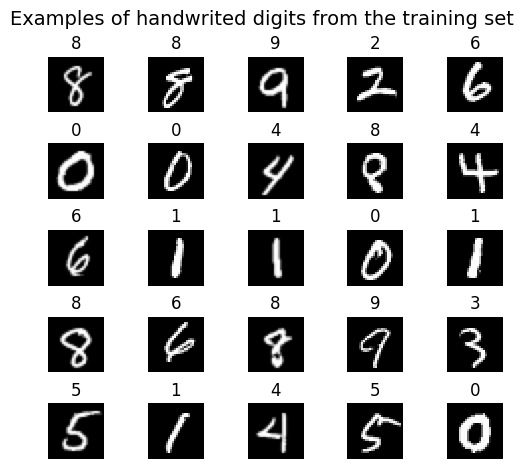

In [4]:
m, n = X.shape

fig, axes = plt.subplots(5,5, figsize=(5,5))
fig.tight_layout(pad=0.12,rect=[0, 0.03, 1, 0.9]) 

for ax in axes.flat:
    
    # select random index from the data and reshape the given image to the original format 28x28
    random_index = np.random.randint(m)
    X_random_reshaped = X.iloc[random_index].values.reshape((28,28))
    
    # display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    ax.set_title(y.iloc[random_index])
    ax.set_axis_off()
    fig.suptitle("Examples of handwrited digits from the training set", fontsize=14)

### NN model 

Now let's split the data and normalize it 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Custom function to train neural network with two hidden layers.

In [6]:
def train_net(X_train, y_train, validation_data=None, nu1=50, nu2=25, nu3=10, activation='relu', regul1=0, regul2=0, 
              dropRate=0, optimizer='adam', epochs=10, batch_size=32):
    
    model = Sequential(
    [   
        tf.keras.Input(shape=(784,)),
        Dense(units = nu1, activation = activation, kernel_regularizer = tf.keras.regularizers.L1L2(l1=regul1, l2=regul2)),
        tf.keras.layers.Dropout(dropRate),
        Dense(units = nu2, activation = activation, kernel_regularizer = tf.keras.regularizers.L1L2(l1=regul1, l2=regul2)),
        tf.keras.layers.Dropout(dropRate),
        Dense(units = nu3, activation = 'linear')   
    ])
    
    # we used linear activation in the last layer, so now we have to set "from_logits=True" in the loss function
    # it's considered to be more numerically stable
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    histModel = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data, verbose=0)
    
    TrainAccuracy = histModel.history['accuracy']
    
    if validation_data != None:
        TestAccuracy = histModel.history['val_accuracy']
        BestScore = max(TestAccuracy)
    else: 
        TestAccuracy = []
        BestScore = 0
    
    return model, histModel, TrainAccuracy, TestAccuracy, BestScore

Training the model (this may take some time)

Train accuracy: 0.9993749856948853
Test accuracy: 0.9800000190734863


<Axes: >

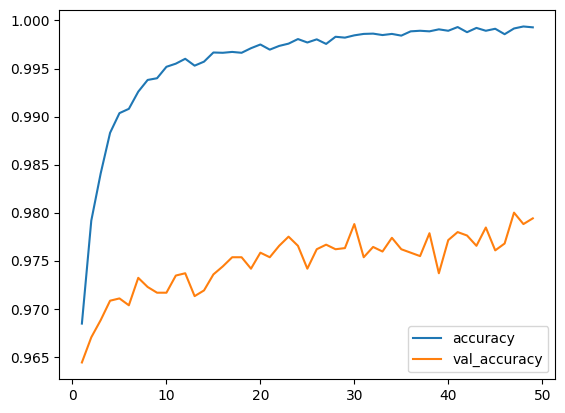

In [7]:
model, histModel, TrainAccuracy, TestAccuracy, BestScore = train_net(X_train, y_train, validation_data=(X_test, y_test),
                                                                     nu1=600, nu2=300, nu3=10, activation='relu', 
                                                                     optimizer='adamax', epochs=50, batch_size=64,
                                                                     regul2=0.001)
print('Train accuracy:', max(TrainAccuracy))
print('Test accuracy:', BestScore)
hist_df = pd.DataFrame(histModel.history)
hist_df.loc[1:,['accuracy', 'val_accuracy']].plot()

Submission

In [8]:
test_df_scaled = scaler.transform(test_df)

predictions = model.predict(test_df_scaled)
predictions = np.argmax(predictions, axis = 1)

submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv', index_col = False)
submission['Label'] = predictions
submission.to_csv('submission.csv', index = False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


### Visualizing misclassified examples

In [9]:
X_test_df = pd.DataFrame(X_test)
X_test_df['prediction'] = np.argmax(model.predict(X_test_df), axis = 1)
X_test_df['label'] = np.array(y_test)

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Let's check which digits are misclassifed the most often. 

<Axes: xlabel='label'>

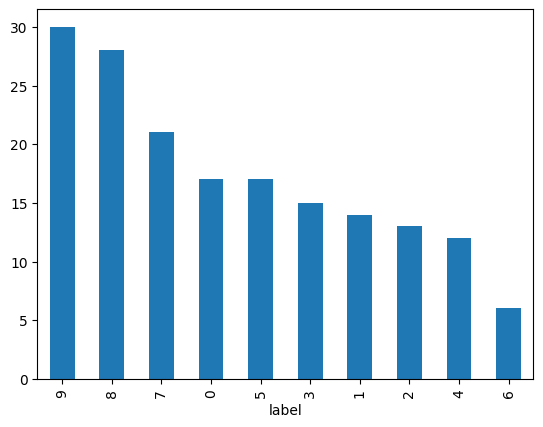

In [10]:
misclassified = X_test_df.loc[X_test_df['prediction'] != X_test_df['label']]
misclassified['label'].value_counts().plot(kind = 'bar')

Finally let's see how these misclassified examples look like.

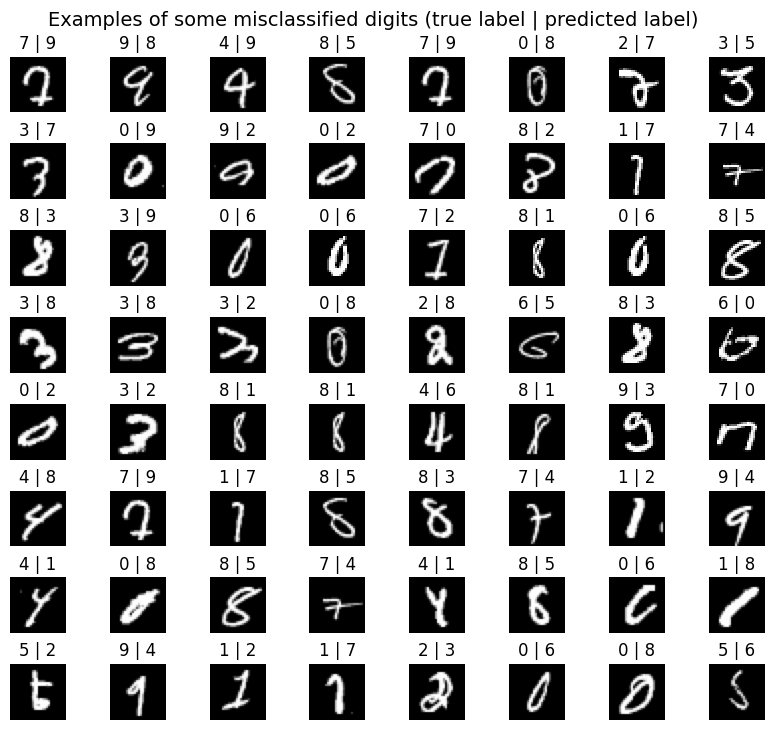

In [11]:
misclassified.iloc[:,:-2] = scaler.inverse_transform(misclassified.iloc[:,:-2])
misclassified.index = range(1,misclassified.shape[0]+1)

m, n = misclassified.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.12,rect=[0, 0.03, 1, 0.9])

pixels = misclassified.iloc[:,:-2]
labels = misclassified.iloc[:,-2:]

for ax in axes.flat:

    random_index = np.random.randint(m)
    pixels_reshaped = pixels.iloc[random_index].values.reshape((28,28))
    
    ax.imshow(pixels_reshaped, cmap='gray')
    ax.set_title(str(labels['label'].iloc[random_index]) + ' | ' + str(labels['prediction'].iloc[random_index]))
    ax.set_axis_off()
    fig.suptitle("Examples of some misclassified digits (true label | predicted label)", fontsize=14, y = 0.95)